## Дипломный проект на тему   
## "Модель прогнозирования стоимости жилья для агентства недвижимости"

In [1085]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.pipeline import Pipeline
import category_encoders as ce
import pickle

Описание данных:  

➔ 'status' — статус продажи;  
➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;  
➔ 'propertyType' — тип объекта недвижимости;  
➔ 'street' — адрес объекта;  
➔ 'baths' — количество ванных комнат;  
➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);  
➔ 'fireplace' — наличие камина;  
➔ 'city' — город;  
➔ 'schools' — сведения о школах в районе;  
➔ 'sqft' — площадь в футах;  
➔ 'zipcode' — почтовый индекс;  
➔ 'beds' — количество спален;  
➔ 'state' — штат;  
➔ 'stories' — количество этажей;  
➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);  
➔ 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

## Знакомство с данными, базовый анализ, EDA, Очистка данных

In [954]:
data = pd.read_csv('data/data.csv')

In [955]:
data.shape

(377185, 18)

In [956]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


Проверяем и удалаяем дубликаты

In [957]:
data.duplicated().sum()

50

In [958]:
data.drop_duplicates(inplace=True, ignore_index=False)

In [959]:
data.shape

(377135, 18)

In [960]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377135 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   street        377133 non-null  object
 4   baths         270827 non-null  object
 5   homeFacts     377135 non-null  object
 6   fireplace     103112 non-null  object
 7   city          377101 non-null  object
 8   schools       377135 non-null  object
 9   sqft          336585 non-null  object
 10  zipcode       377135 non-null  object
 11  beds          285881 non-null  object
 12  state         377135 non-null  object
 13  stories       226462 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40310 non-null   object
 16  MlsId         310266 non-null  object
 17  target        374655 non-null  object
dtypes: object(18)
memory usa

Оцениваем как потенциально могут влиять признаки в зависимости от их уникальных значений

In [961]:
cols = data.columns
for col in cols:
    print(f'Количество уникальных значений у параметра {col} = {data[col].nunique()}'
          + f' и их доля равна {round(data[col].nunique()/data[col].count() * 100)}%')

Количество уникальных значений у параметра status = 159 и их доля равна 0%
Количество уникальных значений у параметра private pool = 1 и их доля равна 0%
Количество уникальных значений у параметра propertyType = 1280 и их доля равна 0%
Количество уникальных значений у параметра street = 337076 и их доля равна 89%
Количество уникальных значений у параметра baths = 229 и их доля равна 0%
Количество уникальных значений у параметра homeFacts = 321009 и их доля равна 85%
Количество уникальных значений у параметра fireplace = 1653 и их доля равна 2%
Количество уникальных значений у параметра city = 2026 и их доля равна 1%
Количество уникальных значений у параметра schools = 297365 и их доля равна 79%
Количество уникальных значений у параметра sqft = 25405 и их доля равна 8%
Количество уникальных значений у параметра zipcode = 4549 и их доля равна 1%
Количество уникальных значений у параметра beds = 1184 и их доля равна 0%
Количество уникальных значений у параметра state = 39 и их доля равна 

Оцениваем, в каких признаках доля пропусков более 30% и их на потенциальное удаление

In [962]:
cols = data.columns
cols_to_drop_probably = []
for col in cols:
    if data[col].count() / data.shape[0] < 0.7:
        cols_to_drop_probably.append(col)
cols_to_drop_probably

['private pool', 'fireplace', 'stories', 'mls-id', 'PrivatePool']

In [963]:
drop_data = data.copy()

Добавляем признак MlsId, не имеющий смысла

In [964]:
drop_data.drop(['private pool', 'fireplace', 'stories', 'mls-id', 'PrivatePool', 'MlsId'], axis=1, inplace=True)

In [965]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377135 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   propertyType  342402 non-null  object
 2   street        377133 non-null  object
 3   baths         270827 non-null  object
 4   homeFacts     377135 non-null  object
 5   city          377101 non-null  object
 6   schools       377135 non-null  object
 7   sqft          336585 non-null  object
 8   zipcode       377135 non-null  object
 9   beds          285881 non-null  object
 10  state         377135 non-null  object
 11  target        374655 non-null  object
dtypes: object(12)
memory usage: 37.4+ MB


Мне не нравится признак baths, в виду того, что в нем много пропусков (29%) и среди представленных данных много не точных (12+, 10,5+, 1/1-0/1-0, 1750 и пр.). Но чуть поработаем

In [967]:
# Удалим все буквы, поскольку нам важно только количество
drop_data['baths'] = drop_data['baths'].str.replace('[a-zA-Z]','', regex=True)
# Удалим все пробелы
drop_data['baths'] = drop_data['baths'].str.replace(' ','', regex=True)
# Удалим :
drop_data['baths'] = drop_data['baths'].str.replace(':','', regex=True)

In [968]:
drop_data['baths'].unique()

array(['3.5', '3', '2', '8', nan, '1,750', '4', '5', '1,000', '7', '2.0',
       '3.0', '1', '4.0', '2.1', '2.5', '4.5', '6', '2,500', '5.5', '1.0',
       '1.5', '~', '4,000', '2,000', '3,000', '8.0', '0', '5.0', '1,500',
       '7.0', '1,250', '9', '2,250', '6.0', '12', '3,500', '2,750', '750',
       '5.5+', '10', '19', '10.0', '2.5+', '7.5+', '0/0', '..', '4.5+',
       '18', '--', '3.5+', '1.5+', '11', '5,000', '1.75', '12.0', '1.1',
       '6.5', '16', '13', '14', '9.0', '8.5+', '17', '241', '16.0',
       '10.5+', '6.5+', '7,500+', '7.5', '11.0', '20', '40', '1-0/1-0/1',
       '14.0', '2.75', '24', '22.0', '0.00', '2.25', '3.1', '3.25', '—',
       '22', '32', '18.0', '0.0', '27', '26', '20.0', '9.5', '8.5', '15',
       '35', '3.75', '29', '116/116/116', '21', '5.2', '14.5+', '76',
       '13.0', '', '3-1/2-2', '15.0', '23', '3.3', '43', '1.25', '34',
       '2.2', '1/1/1/1', '55.0', '25', '12.5+', '44', '0.5', '4.25',
       '4.75', '0.75', '4.1', '5.25', '41.0', '1.8', '10.5

In [969]:
drop_data['baths'] = drop_data['baths'].fillna('unknown')
drop_data['baths'] = drop_data['baths'] \
.str.replace('~','unknown', regex=True) \
.str.replace('\.\.','unknown', regex=True) \
.str.replace('--','unknown', regex=True) \
.str.replace('—','unknown', regex=True) \
.str.replace('^\s*$','unknown', regex=True) \
.str.replace('1-0/1-0/1','unknown', regex=True) \
.str.replace('116/116/116','unknown', regex=True) \
.str.replace('3-1/2-2','unknown', regex=True) \
.str.replace('1/1/1/1','unknown', regex=True) \
.str.replace('2-1/2-1/1-1/1-1','unknown', regex=True) \
.str.replace('1/1-0/1-0/1-0','unknown', regex=True) \
.str.replace('.*unknown.*','unknown', regex=True) \
.str.replace('1-2','unknown', regex=True) \
.str.replace('^0.0+','0', regex=True)

In [970]:
drop_data['baths'] = drop_data['baths'] \
.str.replace('23.0','23', regex=True) \
.str.replace('44.0','44', regex=True) \
.str.replace('34.0','34', regex=True) \
.str.replace('30.0','30', regex=True) \
.str.replace('24.0','24', regex=True) \
.str.replace('241','24', regex=True) \
.str.replace('22.0','22', regex=True) \
.str.replace('20.0','20', regex=True) \
.str.replace('18.0','18', regex=True) \
.str.replace('17.0','17', regex=True) \
.str.replace('16.0','16', regex=True) \
.str.replace('15.0','15', regex=True) \
.str.replace('14.0','14', regex=True) \
.str.replace('13.0','13', regex=True) \
.str.replace('12.0','12', regex=True) \
.str.replace('11.0','11', regex=True) \
.str.replace('10.0','10', regex=True)

In [971]:
drop_data['baths'] = drop_data['baths'].str.replace('+', '').replace('unknown', 0).replace(',', '.')
drop_data['baths'] = drop_data['baths'].str.replace(',', '.')
drop_data['baths'] = drop_data['baths'].astype('float')

C:\Users\minni\AppData\Local\Temp\ipykernel_20136\729927065.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  drop_data['baths'] = drop_data['baths'].str.replace('+', '').replace('unknown', 0).replace(',', '.')


Выделяем пропуски у признака sqft и приводим к числовому формату

In [972]:
drop_data['sqft'] = drop_data['sqft'].apply(lambda x: str(x).lower().replace('sqft', '').replace(',', '').replace(' ', '').replace('--', '').replace('totalinteriorlivablearea:', '').replace('-', '').strip())
drop_data['sqft'] = drop_data['sqft'].apply(lambda x: np.nan if x == '' else x)
drop_data['sqft'] = drop_data['sqft'].astype('float')

Удаляем строки, где пропущены значения целевой переменной

In [973]:
drop_data.dropna(subset=['target'], inplace=True)

Далее удаляем параметр Улица (много уникальных значений) и почтовый индекс (есть город и штат)

In [974]:
drop_data.drop(['street', 'zipcode'], axis=1, inplace=True)

Оцениваем информацию в признаке school

In [975]:
drop_data['schools']

0         [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...
1         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
2         [{'rating': ['8/10', '4/10', '8/10'], 'data': ...
3         [{'rating': ['9/10', '9/10', '10/10', '9/10'],...
4         [{'rating': ['4/10', '5/10', '5/10'], 'data': ...
                                ...                        
377180    [{'rating': ['10/10', '5/10'], 'data': {'Dista...
377181    [{'rating': ['1/10', '5/10', '7/10'], 'data': ...
377182    [{'rating': ['5/10', '4/10'], 'data': {'Distan...
377183    [{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...
377184    [{'rating': ['5/10', '4/10', '3/10'], 'data': ...
Name: schools, Length: 374655, dtype: object

Далее получаем Расстояние до ближайшей школы **min_dist_to_school**

In [976]:
drop_data['min_dist_to_school'] = drop_data['schools'].apply(lambda x: eval(x)[0].get('data').get('Distance'))

drop_data['min_dist_to_school'] = drop_data['min_dist_to_school'].apply(lambda x: list(map(lambda y: float(y.replace('mi', '')), x)))

drop_data['min_dist_to_school'] = drop_data['min_dist_to_school'].apply(lambda x: min(x) if len(x) > 0 else np.NaN)

Совершенно нет времени, но интересно еще поработать с Рейтингом

Оцениваем информацию в признаке homeFacts

In [977]:
drop_data['homeFacts'].unique()

array(["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}",
       "{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}",
       "{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attach

Создаем новые признаки 'Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft'. В дальнейшем избавимся от ненужных.

In [978]:
new_home_facts_cols = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for index, col in enumerate(new_home_facts_cols):
    drop_data[col] = drop_data['homeFacts'].apply(lambda x: eval(x).get('atAGlanceFacts')[index].get('factValue'))

Удаляем признаки 'schools', 'homeFacts' из таблицы

In [979]:
drop_data.drop(['schools', 'homeFacts'], axis=1, inplace=True)

In [980]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              335399 non-null  object 
 1   propertyType        340101 non-null  object 
 2   baths               267819 non-null  float64
 3   city                374621 non-null  object 
 4   sqft                333749 non-null  float64
 5   beds                283726 non-null  object 
 6   state               374655 non-null  object 
 7   target              374655 non-null  object 
 8   min_dist_to_school  370398 non-null  float64
 9   Year built          371090 non-null  object 
 10  Remodeled year      348316 non-null  object 
 11  Heating             371170 non-null  object 
 12  Cooling             371170 non-null  object 
 13  Parking             371170 non-null  object 
 14  lotsize             346453 non-null  object 
 15  Price/sqft          317467 non-nul

Удаляем lotsize и Price/sqft

In [981]:
drop_data.drop(['lotsize', 'Price/sqft'], axis=1, inplace=True)

Далее работаем с признаком beds. Тут я рассмтаривал нескольк овариантов, с учетом отсутсвия времени и большой засорености в данных, уже забывал, что хотел сделать. В итоге алгоритм может излишний, но хотел сперва по разному отмечать пропущенные либо непонятные значения

In [982]:
s = list(range(-2, 200))
s = [str(x) for x in s]

drop_data['new_beds'] = drop_data['beds'].apply(lambda x: -2 if x is np.nan else x)
drop_data['new_beds'] = drop_data['new_beds'].apply(lambda x: str(x).replace(' Beds', '').replace(' bd', '').replace('.0', ''))
drop_data['new_beds'] = drop_data['new_beds'].apply(lambda x: int(x) if (x != '-2') and (x in s) else np.nan)

drop_data.drop(['beds'], axis=1, inplace=True)

drop_data['new_beds'].unique()

array([  4.,   3.,   5.,  nan,   2.,   8.,   1.,   6.,  12.,  14.,   7.,
         9.,   0.,  16.,  13.,  10.,  18.,  20.,  32.,  11.,  26.,  64.,
       144.,  22.,  24.,  15.,  28.,  36.,  19.,  48.,  25.,  17.,  27.,
        40.,  47.,  23.,  44.,  30.,  33.,  31.,  34.,  99.,  78.,  53.,
        51.,  21.,  75.,  29.,  39.,  42.,  52.,  46.,  76.,  35.,  88.])

In [983]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              335399 non-null  object 
 1   propertyType        340101 non-null  object 
 2   baths               267819 non-null  float64
 3   city                374621 non-null  object 
 4   sqft                333749 non-null  float64
 5   state               374655 non-null  object 
 6   target              374655 non-null  object 
 7   min_dist_to_school  370398 non-null  float64
 8   Year built          371090 non-null  object 
 9   Remodeled year      348316 non-null  object 
 10  Heating             371170 non-null  object 
 11  Cooling             371170 non-null  object 
 12  Parking             371170 non-null  object 
 13  new_beds            263550 non-null  float64
dtypes: float64(4), object(10)
memory usage: 42.9+ MB


Проверяем таблицу на потенциальное удаление столбцов

In [984]:
cols = drop_data.columns
cols_to_drop_probably = []
for col in cols:
    if drop_data[col].count() / drop_data.shape[0] < 0.7:
        cols_to_drop_probably.append(col)
cols_to_drop_probably

[]

Работаем с 'Year built'

In [985]:
drop_data['Year built'].unique()

array(['2019', '1961', '2006', '', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', '1994', '1910', '1923', '1960', '1977', '1972',
       '1963', '1981', '1949', '1930', '1991', '1958', '2005', '2017',
       '2018', '1983', '1928', '1998', '1997', '1964', '1974', '1940',
       '1973', '1968', '1999', '1918', '2007', '1984', '1946', '2003',
       '2000', '2004', '1969', '2002', '1952', '1947', '1957', '1978',
       '1956', '1967', '1975', '1988', '1955', '1950', '1959', '2012',
       '1924', '1966', '1992', '2001', '1995', '2010', '1971', '1909',
       '1953', '1993', '1990', '1980', '1985', '1951', '1907', '1885',
       '1941', '1927', '1929', '1901', None, '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1895', '1911', '1948', '1942', '1916', '1900', '1931',
 

Данные до преобразования

In [986]:
drop_data[(drop_data['Year built'] == '') | (drop_data['Year built'] == 'No Data') | (drop_data['Year built'] == '0')]['Year built']

4          
26         
27         
40         
41         
         ..
377140     
377141     
377153     
377154     
377161     
Name: Year built, Length: 59670, dtype: object

Я решил, что если нет информации о годе постойки, но при этом есть даные о годе рконструкции, то можно взять их.

В итоге немного, но они были.Части пропущенных данных о годе строительства берем из данных о реконструкции

In [987]:
dd = drop_data.copy()

In [988]:

for i in dd.index:
    if (dd['Year built'].loc[i] == '') or (dd['Year built'].loc[i] == 'No Data') or (dd['Year built'].loc[i] == '0') or (dd['Year built'].loc[i] is np.nan) or (dd['Year built'].loc[i] is None):
        dd['Year built'].loc[i] = np.nan

C:\Users\minni\AppData\Local\Temp\ipykernel_20136\673592125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['Year built'].loc[i] = np.nan


In [989]:
drop_data['Year built'] = dd['Year built']

Данные после преобразования

In [990]:
drop_data[(drop_data['Year built'] == '') | (drop_data['Year built'] == 'No Data') | (drop_data['Year built'] == '0')]['Year built']

Series([], Name: Year built, dtype: object)

Далее потратил много времени на признак реконструкции, затем решил его удалить.

Заполняем часть пропуском в данных по реконструкции, подразуемевая, что еесли пропуск, то реконструкция соответсвует году строительства

In [991]:
# dd2 = drop_data.copy()

Как показал анализ, Remodeled year нужно удалить из-за большого числа пропусков

In [992]:
# for i in dd2.index:
#     if (dd2['Remodeled year'].loc[i] == '') or (dd2['Remodeled year'].loc[i] == '0') or (dd2['Remodeled year'].loc[i] == 'No Data') or (dd2['Remodeled year'].loc[i] is np.nan) or (dd2['Remodeled year'].loc[i] is None):
#         dd2['Remodeled year'].loc[i] = np.nan

C:\Users\minni\AppData\Local\Temp\ipykernel_20136\1768410461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd2['Remodeled year'].loc[i] = np.nan


In [995]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              335399 non-null  object 
 1   propertyType        340101 non-null  object 
 2   baths               267819 non-null  float64
 3   city                374621 non-null  object 
 4   sqft                333749 non-null  float64
 5   state               374655 non-null  object 
 6   target              374655 non-null  object 
 7   min_dist_to_school  370398 non-null  float64
 8   Year built          311420 non-null  object 
 9   Remodeled year      149564 non-null  object 
 10  Heating             371170 non-null  object 
 11  Cooling             371170 non-null  object 
 12  Parking             371170 non-null  object 
 13  new_beds            263550 non-null  float64
dtypes: float64(4), object(10)
memory usage: 50.9+ MB


In [996]:
cols_null_percent = drop_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
cols_with_null

Remodeled year        60.079540
new_beds              29.655283
baths                 28.515835
Year built            16.878195
sqft                  10.918312
status                10.477906
propertyType           9.222885
min_dist_to_school     1.136245
Heating                0.930189
Cooling                0.930189
Parking                0.930189
city                   0.009075
dtype: float64

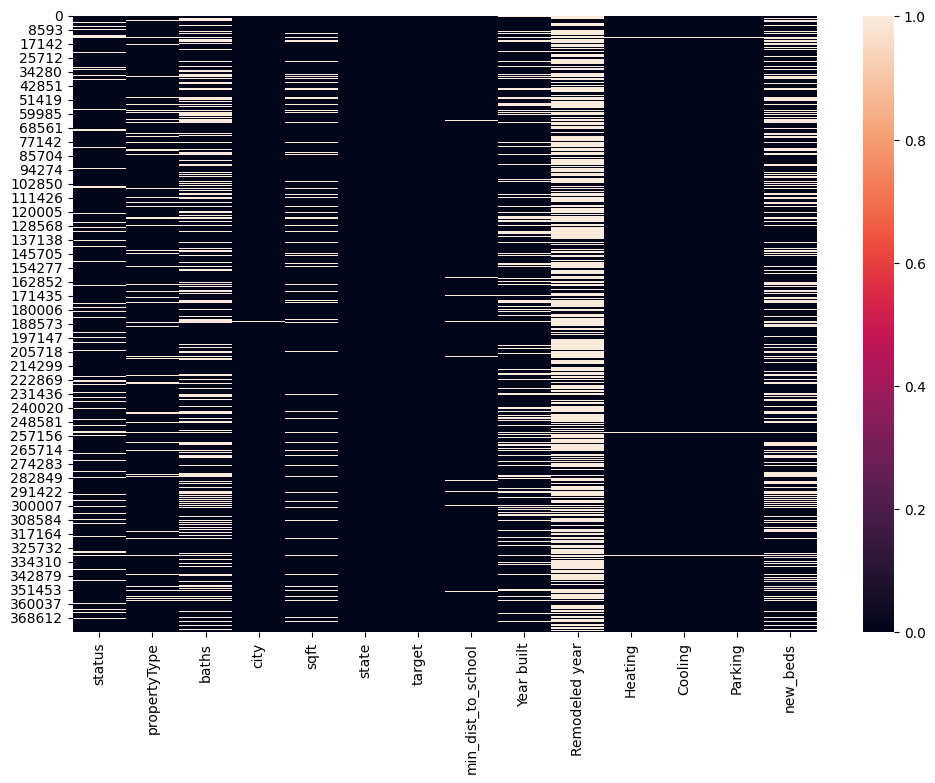

In [997]:
plt.figure(figsize=(12, 8))
sns.heatmap(drop_data.isnull());

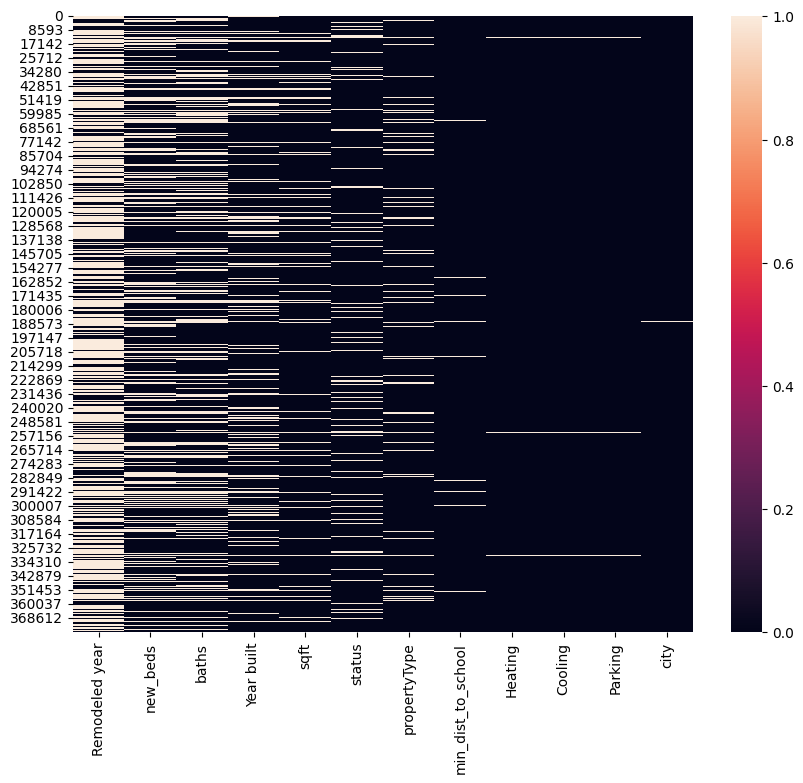

In [998]:
plt.figure(figsize=(10, 8))
sns.heatmap(drop_data[cols_with_null.index].isnull());

**Ниже код привидения к числовому формату**

In [1002]:
drop_data['Year built'] = drop_data['Year built'].astype('float')

In [1003]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              335399 non-null  object 
 1   propertyType        340101 non-null  object 
 2   baths               267819 non-null  float64
 3   city                374621 non-null  object 
 4   sqft                333749 non-null  float64
 5   state               374655 non-null  object 
 6   target              374655 non-null  object 
 7   min_dist_to_school  370398 non-null  float64
 8   Year built          311420 non-null  float64
 9   Remodeled year      149564 non-null  float64
 10  Heating             371170 non-null  object 
 11  Cooling             371170 non-null  object 
 12  Parking             371170 non-null  object 
 13  new_beds            263550 non-null  float64
dtypes: float64(6), object(8)
memory usage: 50.9+ MB


Далее убираем ошибочные данные

In [ ]:
sns.boxplot(drop_data['Year built']);

Удаляем строки, с годом постройки менее 100 и более 2023

In [1004]:
(drop_data['Year built'] > 2023).sum()

4

In [1005]:
(drop_data['Year built'] < 1000).sum()

2

In [1006]:
drop_data = drop_data[(drop_data['Year built'] > 100) & (drop_data['Year built'] < 2024)]

In [1007]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311414 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              276532 non-null  object 
 1   propertyType        294168 non-null  object 
 2   baths               244637 non-null  float64
 3   city                311405 non-null  object 
 4   sqft                303869 non-null  float64
 5   state               311414 non-null  object 
 6   target              311414 non-null  object 
 7   min_dist_to_school  308886 non-null  float64
 8   Year built          311414 non-null  float64
 9   Remodeled year      148225 non-null  float64
 10  Heating             311414 non-null  object 
 11  Cooling             311414 non-null  object 
 12  Parking             311414 non-null  object 
 13  new_beds            245077 non-null  float64
dtypes: float64(6), object(8)
memory usage: 35.6+ MB


Работаем с 'target'

In [1008]:
drop_data['target'].value_counts()

$225,000    1279
$275,000    1206
$299,900    1183
$249,900    1163
$399,000    1150
            ... 
$48,780        1
$197,899       1
$487,524       1
447,365        1
$171,306       1
Name: target, Length: 36822, dtype: int64

In [1009]:
drop_data['target'] = drop_data['target'].apply(lambda x: str(x).replace('$', '').replace(',', '').replace(' ', '').replace('+', ''))

In [1010]:
drop_data['target'].value_counts()

225000    1547
275000    1441
350000    1424
299900    1419
399000    1407
          ... 
215087       1
882000       1
167626       1
216777       1
171306       1
Name: target, Length: 29695, dtype: int64

In [1011]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311414 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              276532 non-null  object 
 1   propertyType        294168 non-null  object 
 2   baths               244637 non-null  float64
 3   city                311405 non-null  object 
 4   sqft                303869 non-null  float64
 5   state               311414 non-null  object 
 6   target              311414 non-null  object 
 7   min_dist_to_school  308886 non-null  float64
 8   Year built          311414 non-null  float64
 9   Remodeled year      148225 non-null  float64
 10  Heating             311414 non-null  object 
 11  Cooling             311414 non-null  object 
 12  Parking             311414 non-null  object 
 13  new_beds            245077 non-null  float64
dtypes: float64(6), object(8)
memory usage: 35.6+ MB


Используем дата сет без сдачи в аренду

In [1012]:
df_fs = drop_data.copy()

In [1013]:
df_fs = df_fs[df_fs['status'] != 'for rent']

In [1014]:
df_fs['target'] = df_fs['target'].astype('int')

In [1015]:
df_fs['target'].describe()

count    3.110280e+05
mean     6.539343e+05
std      1.788873e+06
min      1.000000e+00
25%      2.099000e+05
50%      3.395000e+05
75%      5.990000e+05
max      1.950000e+08
Name: target, dtype: float64

In [1016]:
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311028 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              276146 non-null  object 
 1   propertyType        293782 non-null  object 
 2   baths               244336 non-null  float64
 3   city                311019 non-null  object 
 4   sqft                303493 non-null  float64
 5   state               311028 non-null  object 
 6   target              311028 non-null  int32  
 7   min_dist_to_school  308507 non-null  float64
 8   Year built          311028 non-null  float64
 9   Remodeled year      148225 non-null  float64
 10  Heating             311028 non-null  object 
 11  Cooling             311028 non-null  object 
 12  Parking             311028 non-null  object 
 13  new_beds            244737 non-null  float64
dtypes: float64(6), int32(1), object(7)
memory usage: 34.4+ MB


In [1017]:
df_fs[df_fs['target'] == 1].shape

(10, 14)

Удаляем стоимость равную 1

In [1018]:
df_fs = df_fs[df_fs['target'] > 1]

In [1019]:
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311018 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              276138 non-null  object 
 1   propertyType        293772 non-null  object 
 2   baths               244330 non-null  float64
 3   city                311009 non-null  object 
 4   sqft                303484 non-null  float64
 5   state               311018 non-null  object 
 6   target              311018 non-null  int32  
 7   min_dist_to_school  308497 non-null  float64
 8   Year built          311018 non-null  float64
 9   Remodeled year      148220 non-null  float64
 10  Heating             311018 non-null  object 
 11  Cooling             311018 non-null  object 
 12  Parking             311018 non-null  object 
 13  new_beds            244729 non-null  float64
dtypes: float64(6), int32(1), object(7)
memory usage: 34.4+ MB


Приводим текстовые признаки к нижнему регистру

In [1020]:
cols = ['status', 'propertyType', 'Heating', 'Cooling', 'Parking']
for col in cols:
    df_fs[col] = df_fs[col].str.lower()

In [1021]:
cols = ['status', 'propertyType', 'Heating', 'Cooling', 'Parking']
for col in cols:
    df_fs[col] = df_fs[col].apply(lambda x: np.nan if (x == '') or (x == 'no data') or (x == 'nan') or (x is None) or (x is np.nan) else x)
    print(f'Доля пропусков в столбце {col} = {round(df_fs[col].isna().sum() / df_fs.shape[0]*100)}%')

Доля пропусков в столбце status = 11%
Доля пропусков в столбце propertyType = 6%
Доля пропусков в столбце Heating = 20%
Доля пропусков в столбце Cooling = 23%
Доля пропусков в столбце Parking = 41%


Удаляем Parking и Remodeled year

In [1022]:
df_fs = df_fs.drop(['Parking', 'Remodeled year'], axis=1)

Здесь конечно вызывают вопросы Heating и Cooling, но на них нет времени. Просто добавим моду к ним

Проверяем долю пропусков

In [1023]:
cols = ['status', 'propertyType', 'Heating', 'Cooling']
for col in cols:
    print(f'Доля пропусков в столбце {col} = {round(df_fs[col].isna().sum() / df_fs.shape[0]*100)}%')

Доля пропусков в столбце status = 11%
Доля пропусков в столбце propertyType = 6%
Доля пропусков в столбце Heating = 20%
Доля пропусков в столбце Cooling = 23%


Удаляем строки с двумя и более пропусками

In [1024]:
print(f'До удаления {df_fs.shape}')
m = df_fs.shape[1] #число признаков после удаления столбцов
df_fs.dropna(thresh=m-2, axis=0, inplace=True)
print(f'После удаления {df_fs.shape}')

До удаления (311018, 12)
После удаления (270666, 12)


Работаем со status

Встречаются значения, отличающиеся запятой или наличием лишнего пробела, например 'pending, continue to show', 'pending continue to show', 'pending   continue to show'. Чтобы избавится от подобного удалим все пробелы и запятые

Также присутствуют значения 'pendingwithcontingencies' и 'pendingw/cont.'. Объединим их в одно.

In [1025]:
df_fs['status'] = df_fs['status'].str.replace('a active','active')
df_fs['status'] = df_fs['status'].str.replace(' ','').str.replace(',','')
df_fs['status'] = df_fs['status'].str.replace('pendingw/cont.','pendingwithcontingencies')



C:\Users\minni\AppData\Local\Temp\ipykernel_20136\361438481.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fs['status'] = df_fs['status'].str.replace('pendingw/cont.','pendingwithcontingencies')


Объединим 'active-contingent', 'active/contingent', 'activecontingency', 'activewithcontingencies', 'activecontingent' в одно

In [1026]:
df_fs['status'] = df_fs['status'] \
.str.replace('active-contingent','activecontingent') \
.str.replace('active/contingent','activecontingent') \
.str.replace('activecontingency','activecontingent') \
.str.replace('activewithcontingencies','activecontingent')

In [1027]:
df_fs['status'].value_counts()

forsale              161247
active                52772
foreclosure            5335
newconstruction        4691
pending                4231
                      ...  
contingentnoshow          1
pendingsale               1
comingsoon:oct24.         1
comingsoon:oct21.         1
comingsoon:dec23.         1
Name: status, Length: 125, dtype: int64

Объединим '/auction' с 'auction', а 'auction-active' с 'active-auction'

In [1028]:
df_fs['status'] = df_fs['status'] \
.str.replace('/auction','auction') \
.str.replace('active-auction','auction-active')

In [1029]:
df_fs['status'].value_counts()

forsale                  161247
active                    52772
foreclosure                5335
newconstruction            4691
pending                    4231
                          ...  
comingsoon:dec15.             1
comingsoon:nov23.             1
pendingw/backupwanted         1
pendingbackupswanted          1
comingsoon:dec23.             1
Name: status, Length: 124, dtype: int64

Объединим 'undercontract' с 'uundercontract', а 'undercontractshowing' с 'undercontractshow' и 'undercontract-show'

In [1030]:
df_fs['status'] = df_fs['status'] \
.str.replace('uundercontract','undercontract') \
.str.replace('undercontractshowing','undercontractshow') \
.str.replace('undercontract-show','undercontractshow') 

Значения "Coming soon:". Объединим все эти значения по первым двум словам, исключив конкретную дату.

In [1031]:
df_fs['status'] = df_fs['status'].str.replace('^comingsoon.*','comingsoon', regex=True)

Есть значения 'recentlysold' и 'sold:...' с какой-то суммой. Объединим их.

In [1032]:
df_fs['status'] = df_fs['status'].str.replace('^sold.*','recentlysold', regex=True)

propertyType. Визуально сразу можно объединить singl family

In [1041]:
df_fs['propertyType'] = df_fs['propertyType'].str.replace('single-family home', 'single family')
df_fs['propertyType'] = df_fs['propertyType'].str.replace('single family home', 'single family')


In [1042]:
df_fs['propertyType'].value_counts()

single family                                   165441
condo                                            38074
townhouse                                        15446
condo/townhome/row home/co-op                     7435
multi-family                                      6934
                                                 ...  
colonial, duplex                                     1
condo/townhome, french, split level                  1
other, ranch                                         1
single detached, southwestern                        1
single detached, early american, traditional         1
Name: propertyType, Length: 861, dtype: int64

In [1043]:
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270666 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              240229 non-null  object 
 1   propertyType        268734 non-null  object 
 2   baths               235276 non-null  float64
 3   city                270659 non-null  object 
 4   sqft                268270 non-null  float64
 5   state               270666 non-null  object 
 6   target              270666 non-null  int32  
 7   min_dist_to_school  269062 non-null  float64
 8   Year built          270666 non-null  float64
 9   Heating             238899 non-null  object 
 10  Cooling             224117 non-null  object 
 11  new_beds            237212 non-null  float64
dtypes: float64(5), int32(1), object(6)
memory usage: 25.8+ MB


In [1034]:
df_fs['Cooling'].value_counts()

central                                                                                         154349
central air                                                                                      10706
none                                                                                              7139
has cooling                                                                                       7003
central electric                                                                                  5937
                                                                                                 ...  
air conditioning, central a/c, dual                                                                  1
heat pump, reversed cycle unit                                                                       1
blowers, forced air, hot air                                                                         1
g-energy star hvac, g-fresh air ventilation, gas hot air/furnace, multizo

In [1035]:
df_fs['Heating'].value_counts()

forced air                                                      130885
other                                                            28233
heat pump                                                         8394
gas                                                               6888
central electric                                                  6833
                                                                 ...  
hot air, stove-pellet                                                1
exhaust fans                                                         1
central, exhaust fans, natural gas, zoned                            1
br closet-electric - new                                             1
baseboard, hot water, programmable thermostat, radiant floor         1
Name: Heating, Length: 1838, dtype: int64

Заполняем пропуски

In [1047]:
fill_data = df_fs.copy()
values = {
    'city': fill_data['city'].mode()[0],
    # 'status': fill_data['status'].mode()[0],
    'status': 'unknown',
    'propertyType': fill_data['propertyType'].mode()[0],
    'baths': fill_data['baths'].median(),
    'sqft': fill_data['sqft'].median(),
    'Heating': fill_data['Heating'].mode()[0],
    'Cooling': fill_data['Cooling'].mode()[0],
    'new_beds': fill_data['new_beds'].mode()[0],
    'Year built': fill_data['Year built'].mode()[0],
    # 'Remodeled year': fill_data['Year built'],
    'min_dist_to_school': fill_data['min_dist_to_school'].median(),
}
#заполняем оставшиеся записи константами в соответствии со словарем values
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
display(fill_data.isna().mean())

status                0.0
propertyType          0.0
baths                 0.0
city                  0.0
sqft                  0.0
state                 0.0
target                0.0
min_dist_to_school    0.0
Year built            0.0
Heating               0.0
Cooling               0.0
new_beds              0.0
dtype: float64

In [1048]:
fill_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270666 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              270666 non-null  object 
 1   propertyType        270666 non-null  object 
 2   baths               270666 non-null  float64
 3   city                270666 non-null  object 
 4   sqft                270666 non-null  float64
 5   state               270666 non-null  object 
 6   target              270666 non-null  int32  
 7   min_dist_to_school  270666 non-null  float64
 8   Year built          270666 non-null  float64
 9   Heating             270666 non-null  object 
 10  Cooling             270666 non-null  object 
 11  new_beds            270666 non-null  float64
dtypes: float64(5), int32(1), object(6)
memory usage: 25.8+ MB


Удалим выбросы у нескольких признаков

In [1050]:
fill_data['target'].describe()

count    2.706660e+05
mean     6.595715e+05
std      1.810489e+06
min      3.930000e+02
25%      2.099000e+05
50%      3.399000e+05
75%      5.992908e+05
max      1.950000e+08
Name: target, dtype: float64

<Axes: >

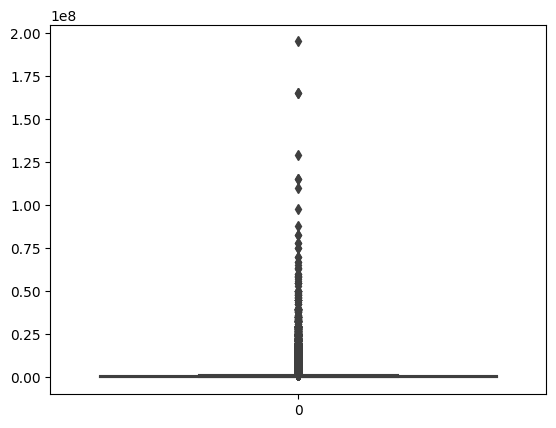

In [1051]:
sns.boxplot(fill_data['target'])

In [1052]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned


In [1053]:
outliers, cleaned = outliers_iqr(fill_data, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 27780
Результирующее число записей: 242886


<Axes: >

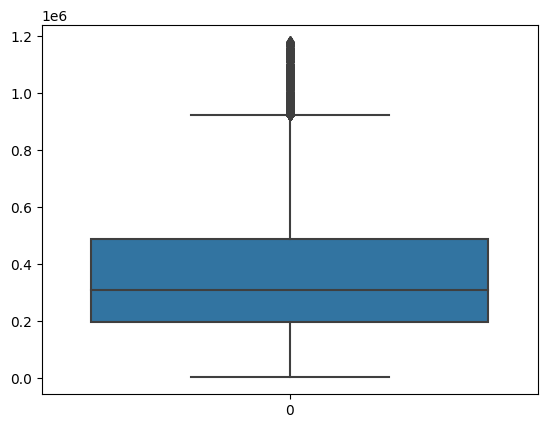

In [1054]:
sns.boxplot(cleaned['target'])

<Axes: >

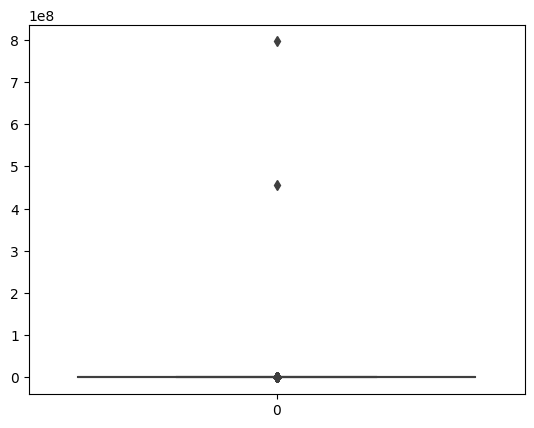

In [1055]:
sns.boxplot(cleaned['sqft'])

In [1056]:
outliers, cleaned = outliers_iqr(cleaned, 'sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 7855
Результирующее число записей: 235031


<Axes: >

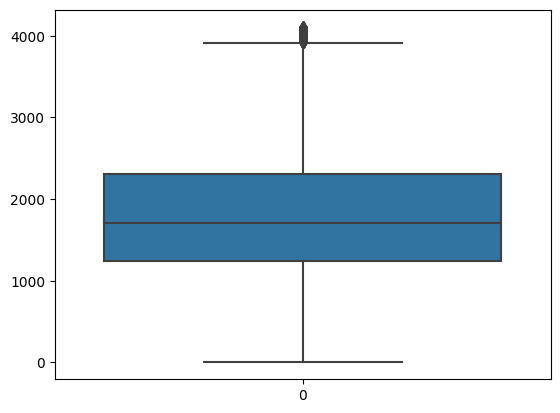

In [1057]:
sns.boxplot(cleaned['sqft'])

При этом еще можно поработать с остальными числовыми признаками, сделаю, если будет время

Бегло посмотрим на распрдеелние признака target

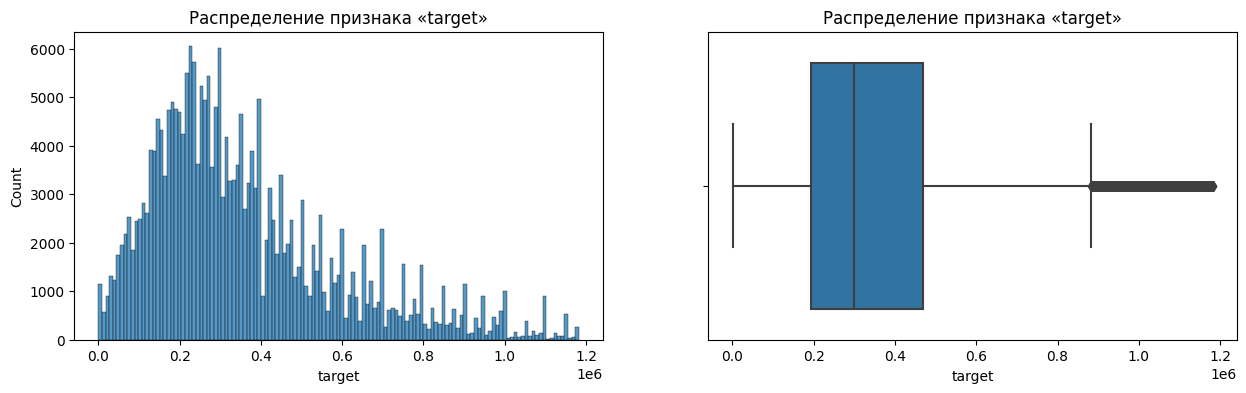

In [1103]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='target', ax=axes[0]);
histplot.set_title('Распределение признака «target»');

boxplot = sns.boxplot(data=cleaned, x='target', ax=axes[1]);
boxplot.set_title('Распределение признака «target»');

Бегло посмотрим на распрдеелние признака sqft

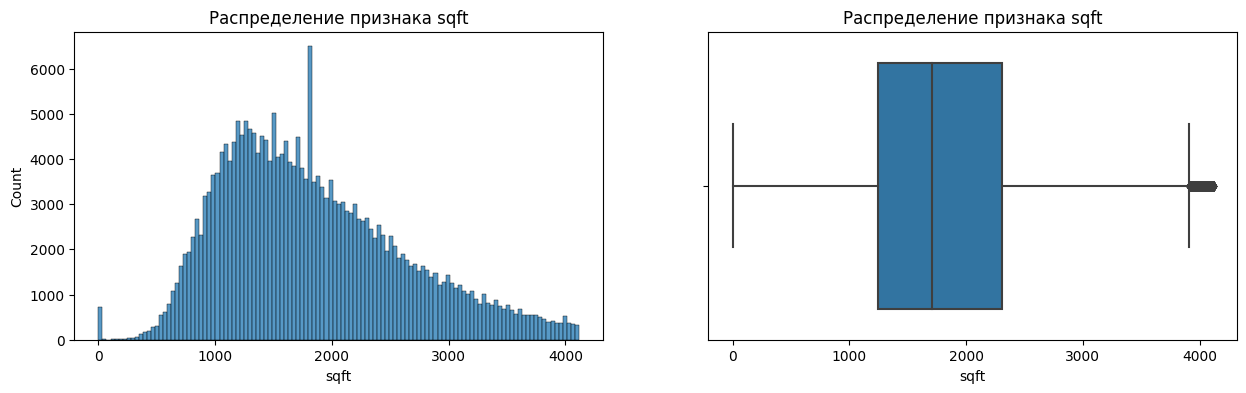

In [1104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='sqft', ax=axes[0]);
histplot.set_title('Распределение признака sqft');

boxplot = sns.boxplot(data=cleaned, x='sqft', ax=axes[1]);
boxplot.set_title('Распределение признака sqft');

Похоже на смещенное нормальное распределение (логнормальное). В принципе от стоимости и площади этого можно ожидать.

## Решение задачи регрессии

Измерять качество наших моделей будем по метрике RMSE (Root Mean Squared Error) и R2_Score.

In [1059]:
model_data = cleaned.copy()

In [1060]:
cat_features = model_data.select_dtypes(include=[object]).columns

In [1061]:
encoder = CatBoostEncoder()
encoder.fit(model_data[cat_features], model_data['target'])
encoded_features = encoder.transform(model_data[cat_features])

# Объединение преобразованных признаков с остальными данными
encoded_data = pd.concat([model_data.drop(cat_features, axis=1), encoded_features], axis=1)

In [1062]:
encoded_data

,baths,sqft,target,min_dist_to_school,Year built,new_beds,status,propertyType,city,state,Heating,Cooling
0,3.5,2900.0,418000,2.70,2019.0,4.0,359410.852043,349200.834554,377779.821568,327609.293060,377515.359796,361860.213321
1,3.0,1947.0,310000,1.01,2019.0,3.0,363571.869973,349200.834554,310829.655894,501033.855920,364368.299121,361860.213321
5,2.5,897.0,209000,0.62,1920.0,2.0,363571.869973,356040.127997,296507.489991,279088.087912,364368.299121,361860.213321
6,2.5,1507.0,181500,0.80,2006.0,3.0,359410.852043,324532.657671,239751.479200,348186.383903,293902.310280,319633.011568
8,2.0,3588.0,244900,5.60,1970.0,3.0,359410.852043,349200.834554,176870.732475,182490.987447,364368.299121,361860.213321
...,...,...,...,...,...,...,...,...,...,...,...,...
377176,2.0,1829.0,171306,1.10,1962.0,3.0,360473.408600,349200.834554,309897.712428,348186.383903,364368.299121,361860.213321
377179,3.0,1417.0,799000,0.10,2010.0,2.0,363571.869973,385828.521799,582182.327280,582182.327280,364368.299121,361860.213321
377181,3.0,2000.0,674999,0.40,1924.0,3.0,363571.869973,385828.521799,346794.912680,321509.863857,457986.105430,361860.213321
377182,3.0,1152.0,528000,0.48,1950.0,3.0,363571.869973,349200.834554,672753.461873,549139.995114,326021.697400,361860.213321


In [1063]:
X = encoded_data.drop('target', axis=1)
y = encoded_data['target']

In [1064]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

In [1065]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.transform(X)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (164521, 77)
Test shape: (70510, 77)


**Первая модель**, самая простая

In [1066]:
# ваш код здесь
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [1067]:
print('MSE')
print(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

print('R2')
print(metrics.r2_score(y_train, y_train_pred))
print(metrics.r2_score(y_test, y_test_pred))

MSE
148599.1299890113
148636.82480621664
R2
0.5866063980955377
0.5896196739903747


**Вторая модель**, полимиальные признакм

In [1068]:
# ваш код здесь
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred_poly = lr_poly.predict(X_train_scaled_poly)
y_test_pred_poly = lr_poly.predict(X_test_scaled_poly)

In [1069]:
print('MSE')
print(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_poly)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_poly)))
print('R2')
print(metrics.r2_score(y_train, y_train_pred_poly))
print(metrics.r2_score(y_test, y_test_pred_poly))

MSE
141580.49268260857
148111.10494309312
R2
0.6247350042579691
0.5925175231625563


**Модель 3**. Кросс-валидация

In [1070]:
# ваш код здесь
lr2 = linear_model.LinearRegression()
metr = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2']
cv_results = model_selection.cross_validate(lr2, X, y, scoring=metr[2], cv=5, return_train_score=True)

print('R2 на тренировочных фолдах: {:.3f}'.format(cv_results['train_score'].mean()))
print('R2 на валидационных фолдах: {:.3f}'.format(cv_results['test_score'].mean()))

R2 на тренировочных фолдах: 0.588
R2 на валидационных фолдах: 0.587


**Модель 4**. Деревья на поли признаках


In [1071]:
dtr_poly = tree.DecisionTreeRegressor(max_depth=8, random_state=42)
dtr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred_poly2 = dtr_poly.predict(X_train_scaled_poly)
y_test_pred_poly2 = dtr_poly.predict(X_test_scaled_poly)

In [1072]:
print('MSE')
print(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_poly2)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_poly2)))
print('R2')
print(metrics.r2_score(y_train, y_train_pred_poly2))
print(metrics.r2_score(y_test, y_test_pred_poly2))

MSE
134519.06493767732
137376.10207429095
R2
0.6612347170984061
0.6494450753610508


Моднль 5. Базовые деревья

In [1073]:
dtr = tree.DecisionTreeRegressor(max_depth=8, random_state=42)
dtr.fit(X_train_scaled, y_train)

y_train_pred2 = dtr.predict(X_train_scaled)
y_test_pred2 = dtr.predict(X_test_scaled)

In [1074]:
print('MSE')
print(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred2)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred2)))
print('R2')
print(metrics.r2_score(y_train, y_train_pred2))
print(metrics.r2_score(y_test, y_test_pred2))

MSE
136982.70028056492
139557.77094459755
R2
0.648712526765342
0.6382223429524545


**Модель 6**. Ансамбли, деревья, поли признаки

In [1075]:
rfr_poly = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split = 20,
    random_state=42,
    verbose=True,
    n_jobs=-1)
rfr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred_poly3 = rfr_poly.predict(X_train_scaled_poly)
y_test_pred_poly3 = rfr_poly.predict(X_test_scaled_poly)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


In [1076]:
print('MSE')
print(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_poly3)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_poly3)))
print('R2')
print(metrics.r2_score(y_train, y_train_pred_poly3))
print(metrics.r2_score(y_test, y_test_pred_poly3))

MSE
110113.64242463243
121941.77292231696
R2
0.7730064719773098
0.7237904416274463


**Модель 7**. Ансамбли, деревья, обычные признаки

In [1077]:
rfr = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split = 20,
    random_state=42,
    verbose=True,
    n_jobs=-1)
rfr_poly.fit(X_train_scaled, y_train)

y_train_pred3 = rfr_poly.predict(X_train_scaled)
y_test_pred3 = rfr_poly.predict(X_test_scaled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   30.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


In [1078]:
print('MSE')
print(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred3)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred3)))
print('R2')
print(metrics.r2_score(y_train, y_train_pred3))
print(metrics.r2_score(y_test, y_test_pred3))

MSE
112271.71827653186
121725.83384683378
R2
0.7640217608724456
0.724767820009623


**Модель 8**. Градиентный бустинг

In [1079]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

In [1080]:
print('MSE')
print(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict_gbr)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict_gbr)))
print('R2')
print(metrics.r2_score(y_train, y_train_predict_gbr))
print(metrics.r2_score(y_test, y_test_predict_gbr))

MSE
107416.71389714726
117457.97900424422
R2
0.78398946039685
0.7437294260064802


Модель показала лучший прогноз, хотя на мой взгляд либо намного больше времени, либо нужно иметь практику  и опыт работы в данном направлении, либо дата сет оочень грязный. В первую очередь это очистка дата сета

Посмотрим на важность факторов для наилучшей ансамблевой модели.

<Axes: >

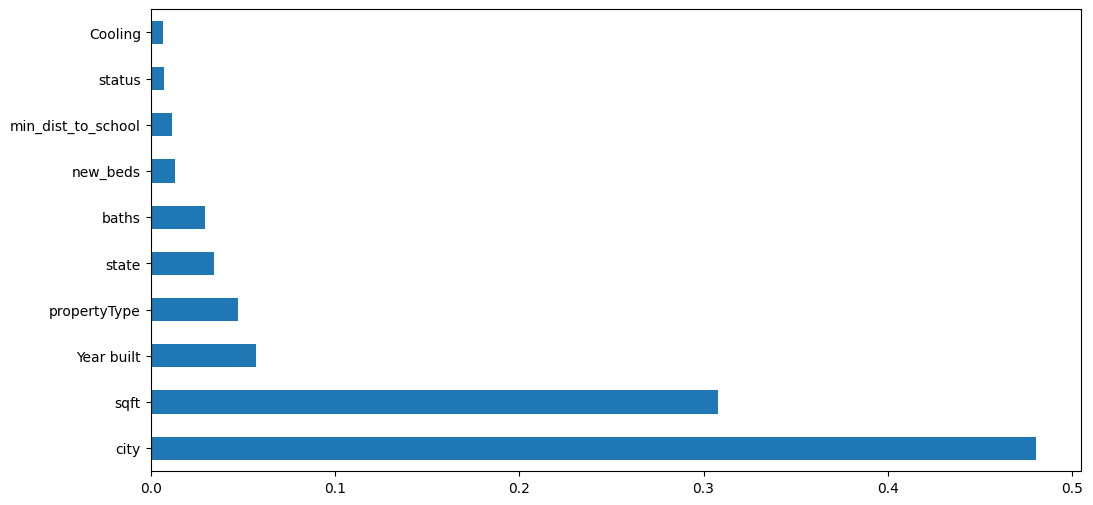

In [1082]:
# есть возможность вывести самые важные признаки для модели через атрибут feature_importances_
plt.rcParams['figure.figsize'] = (12,6)
feat_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

Ожтдаемо, регион - city и площадь - самые значимые факторы

## Подготовка модели к продакшену

In [1083]:
cleaned

,status,propertyType,baths,city,sqft,state,target,min_dist_to_school,Year built,Heating,Cooling,new_beds
0,active,single family,3.5,Southern Pines,2900.0,NC,418000,2.70,2019.0,"central a/c, heat pump",central,4.0
1,forsale,single family,3.0,Spokane Valley,1947.0,WA,310000,1.01,2019.0,forced air,central,3.0
5,forsale,townhouse,2.5,Philadelphia,897.0,PA,209000,0.62,1920.0,forced air,central,2.0
6,active,florida,2.5,POINCIANA,1507.0,FL,181500,0.80,2006.0,"electric, heat pump",central air,3.0
8,active,single family,2.0,Mason City,3588.0,IA,244900,5.60,1970.0,forced air,central,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
377176,unknown,single family,2.0,Orlando,1829.0,FL,171306,1.10,1962.0,forced air,central,3.0
377179,forsale,condo,3.0,Washington,1417.0,DC,799000,0.10,2010.0,forced air,central,2.0
377181,forsale,condo,3.0,Chicago,2000.0,IL,674999,0.40,1924.0,radiant,central,3.0
377182,forsale,single family,3.0,Jamaica,1152.0,NY,528000,0.48,1950.0,other,central,3.0


In [1092]:
cols = cleaned.drop(['target'],axis=1).columns

In [1086]:
# Создаём пайплайн, который включает все наши шаги по подготовке данных и обучению модели
pipe = Pipeline([  
  ('CatBoostEncoder', encoder),
  ('MinMaxScaler', scaler),
  ('GradientBoostingRegressor', gbr)
  ])

In [1087]:
# Входными данными для пайплайна будут
X_p = cleaned.drop(['target'], axis=1)
y_p = cleaned['target']

In [1088]:
# Обучаем пайплайн
pipe.fit(X_p, y_p)

Pipeline(steps=[('CatBoostEncoder',
                 CatBoostEncoder(cols=['status', 'propertyType', 'city',
                                       'state', 'Heating', 'Cooling'])),
                ('MinMaxScaler', MinMaxScaler()),
                ('GradientBoostingRegressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           min_samples_split=30,
                                           random_state=42))])

In [1089]:
# Сериализуем и записываем результат в файл
with open('diplom_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Проверю работоспособность

In [1090]:
# Десериализуем pipeline из файла
with open('diplom_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

In [1096]:
# сделаю предсказание
request = ['active', 'single family', 2, 'Philadelphia', 1000, 'PA', 1, 2019, 'central a/c, heat pump', 'central', 3]
req_f = pd.DataFrame([request], columns=cols)
pred = loaded_pipe.predict(req_f)


### Продакшн

In [1097]:
!pip freeze > requirements.txt

### Посредством Flask реализована вэб версия посредством POST запросов

Файла сервера и клиента прилагаются